# Example: hierarchical inference with importance sampling and MC integration

## The Problem

We have $N$ galaxies with a distribution of stellar masses. We want to recover the hyperparameters describing this distribution.

Let's generate the data.

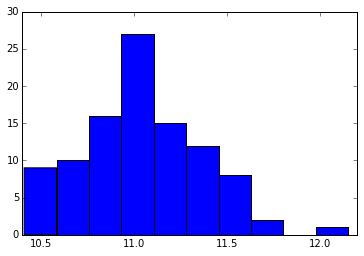

In [1]:
%matplotlib inline

import numpy as np
import pylab

ngal = 100
mu = 11.
sig = 0.3

mstar = np.random.normal(mu, sig, ngal)

#let's add some observational error

merr = 0.1
mstar_obs = mstar + np.random.normal(0., merr, ngal)

# here's the distribution in observed stellar mass

pylab.hist(mstar_obs)
pylab.show()

Let's define our model: let's assume the distribution in stellar mass is a Gaussian with mean $\mu$ and dispersion $\sigma$. These are the hyperparameters. Then there are the parameters describing the individual galaxies: in this case, the stellar mass of each object $M_{*,i}$. We want to fit for the hyperparameters, marginalizing over the individual stellar masses. Finally, there's the data: the observed values of the individual stellar masses $M_{*,i}^{obs}$.

We wish to evaluate the posterior probability distribution of the hyperparameters given the data. From Bayes theorem,

$P(\mu,\sigma|\{M_{*,i}^{obs}\}) = P(\mu,\sigma)P(\{M_{*,i}^{obs}\}|\mu,\sigma) = P(\mu,\sigma)\prod_i \int M_{*,i} P(\{M_{*,i}^{obs}\}|M_{*,i})P(M_{*,i}|\mu,\sigma)$.

In order to sample this posterior probability distribution we need to evaluate the individual likelihoods for each object $P(\{M_{*,i}^{obs}\}|M_{*,i})$. If the likelihood is Gaussian (and in this case it is), then this term can be easily evaluated. However in general it will not be and we'll have to evaluate it numerically. Since it is practically impossible to numerically evaluate $P(\{M_{*,i}^{obs}\}|M_{*,i})$ for every possible value of $M_{*,i}$ we need to use an MCMC trick. The closest thing to $P(\{M_{*,i}^{obs}\}|M_{*,i})$ that we can evaluate is the posterior probability distribution for $M_{*,i}$ given the data $M_{*,i}^{obs}$ assuming some prior $P(M_{*,i}|I_0)$, which we call the *interim prior*. Then we can write

$P(\{M_{*,i}^{obs}\}|M_{*,i}) = \frac{P(M_{*,i}|I_0)P(\{M_{*,i}^{obs}\}|M_{*,i})}{P(M_{*,i}|I_0)} = \frac{P(M_{*,i}|M_{*,i}^{obs}, I_0)}{P(M_{*,i}|I_0)}$.

In practice, the interim prior can be a uniform distribution or a Gaussian, provided that it's broad enough such that $P(\{M_{*,i}^{obs}\}|M_{*,i})$ vanishes at the edges of the distribution. At this point we can sample the numerator of the right hand side of the above equation, which we call the *interim posterior*, with an MCMC of $K$ elements. This needs to be done only once per object. Then, we use those chains to perform the integrals above via Monte Carlo integration:

$\int M_{*,i} P(\{M_{*,i}^{obs}\}|M_{*,i})P(M_{*,i}|\mu,\sigma) = \int M_{*,i} \frac{P(M_{*,i}|M_{*,i}^{obs}, I_0)}{P(M_{*,i}|I_0)} P(M_{*,i}|\mu,\sigma) \approx \frac{1}{K}\Sigma_k \frac{P(M_{*,ik}|M_{*,i}^{obs}, I_0)}{P(M_{*,ik}|I_0)} P(M_{*,ik}|\mu,\sigma)$.

This trick is called *importance sampling* and is a two-step process. In the first step we sample the interim posteriors as follows:

 [-----------------100%-----------------] 5000 of 5000 complete in 0.2 sec

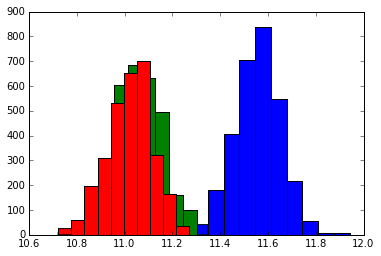

In [10]:
import pymc

nstep = 5000
burnin = 2000

chains = []

for i in range(ngal):
    
    mpar = pymc.Uniform('mstar_%d'%i, lower=9., upper=13., value=mstar_obs[i])
    
    like = pymc.Normal('like_%d'%i, mu=mpar, tau=1./merr**2, value=mstar_obs[i], observed=True)
    
    M = pymc.MCMC([mpar])
    M.sample(nstep, burnin)
    
    chains.append(M.trace('mstar_%d'%i)[:])

# let's look at some of these chains for sanity check
for i in range(3):
    pylab.hist(chains[i])
pylab.show()

Then the posterior for the hyperparameters $\mu$ and $\sigma$ is sampled using the interim posteriors for the individual likelihood terms and weighting them by the term $P(M_{*,ik}|\mu,\sigma)$ when evaluating the integrals over $M_{*,i}$ numerically.

 [-----------------100%-----------------] 11000 of 11000 complete in 29.8 sec

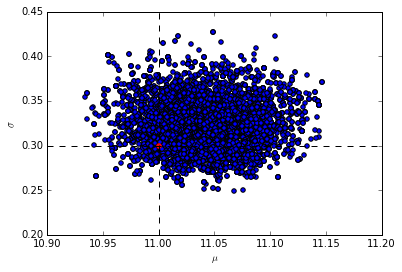

In [8]:
mupar = pymc.Uniform('mu', lower=10., upper=12., value=mstar_obs.mean())
sigpar = pymc.Uniform('sig', lower=0., upper=1., value=mstar_obs.std())

pars = [mupar, sigpar]

@pymc.deterministic
def likeprod(p=pars):
    mu, sig = p
    sumlogp = 0.
    
    for i in range(ngal): #importance sampling and Monte Carlo integration for each galaxy
        iterm = 1./(2.*np.pi)**0.5/sig*np.exp(-0.5*(chains[i] - mu)**2/sig**2)
        
        sumlogp += np.log(iterm.sum())
        
    return sumlogp

@pymc.stochastic
def logp(p=pars, value=0., observed=True):
    return likeprod

M = pymc.MCMC(pars)
M.use_step_method(pymc.AdaptiveMetropolis, pars)
M.sample(11000, 1000)

pylab.scatter(M.trace('mu')[:], M.trace('sig')[:])
pylab.scatter(mu, sig, color='r')
pylab.axhline(sig, color='k', linestyle='--')
pylab.axvline(mu, color='k', linestyle='--')
pylab.xlabel('$\mu$')
pylab.ylabel('$\sigma$')
pylab.show()

Et voilà